In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sdss_df = pd.read_hdf("sdss_training_set.h5")
print(sdss_df)
#sns.pairplot(sdss_df, hue = 'class', diag_kind = 'hist')

       psfMag_r  fiberMag_r  fiber2Mag_r  petroMag_r  deVMag_r  expMag_r  \
0      18.50319    18.65275     19.33509    17.54539  17.31526  17.58132   
1      19.02659    19.32441     19.80892    19.05827  19.03468  19.03111   
2      19.88090    19.77895     20.46623    19.35340  19.18640  19.35493   
3      22.03563    22.06141     22.68416    21.51795  21.03554  21.31751   
4      21.56726    21.57312     22.22178    20.45830  19.93309  20.39825   
...         ...         ...          ...         ...       ...       ...   
19995  21.57356    21.80298     22.35649    20.99044  20.88355  21.20975   
19996  21.68919    21.87613     22.46473    20.89817  20.64549  21.05897   
19997  21.22554    21.35892     21.96298    20.31707  20.09781  20.46114   
19998  18.13591    18.49232     18.97856    18.17947  18.12960  18.12960   
19999  18.79699    19.16370     19.64544    18.83228  18.80138  18.80138   

       modelMag_r  cModelMag_r   class  
0        17.58132     17.48715  GALAXY  
1    

In [5]:
from sklearn.model_selection import train_test_split
rs = 1851

feats = list(sdss_df.columns)
feats.remove('class')

X = np.array(sdss_df[feats])
y = np.array(sdss_df['class'])

train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.3, random_state = rs)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=25)
knn_clf.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=25)

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=50, random_state=rs, n_jobs=-1)
rf_clf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=1851)

In [8]:
feat_str = ',\n'.join(['{}'.format(feat) for feat in np.array(feats)[np.argsort(rf_clf.feature_importances_)[::-1]]])

print('From most to least important: \n{}'.format(feat_str))

From most to least important: 
psfMag_r,
fiber2Mag_r,
deVMag_r,
fiberMag_r,
petroMag_r,
modelMag_r,
cModelMag_r,
expMag_r


In [9]:
from sklearn.metrics import accuracy_score

phot_y = np.empty_like(train_y)
phot_gal = np.logical_not(train_X[:,0] - train_X[:,-1] < 0.145)
phot_y[phot_gal] = 'GALAXY'
phot_y[~phot_gal] = 'STAR'

print("The baseline FoM = {:.4f}".format(accuracy_score(train_y, phot_y)))

The baseline FoM = 0.9672


In [10]:
from sklearn.model_selection import cross_val_score

knn_cv = cross_val_score(knn_clf, train_X, train_y, cv=10)

print('The kNN model FoM = {:.4f} +/- {:.4f}'.format(np.mean(knn_cv), np.std(knn_cv, ddof=1)))

The kNN model FoM = 0.9707 +/- 0.0031


In [11]:
rf_cv = cross_val_score(rf_clf, train_X, train_y, cv=10)

print('The RF model FoM = {:.4f} +/- {:.4f}'.format(np.mean(rf_cv), np.std(rf_cv, ddof=1)))

The RF model FoM = 0.9713 +/- 0.0031


In [12]:
for k in [1,10,100]:
    knn_cv = cross_val_score(KNeighborsClassifier(n_neighbors=k), train_X, train_y, cv=10)

    print('With k = {:d}, the kNN FoM = {:.4f} +/- {:.4f}'.format(k, np.mean(knn_cv), np.std(knn_cv, ddof=1)))

With k = 1, the kNN FoM = 0.9595 +/- 0.0055
With k = 10, the kNN FoM = 0.9720 +/- 0.0033
With k = 100, the kNN FoM = 0.9676 +/- 0.0047


In [13]:
for ntree in [1,10,30,100,300]:    
    rf_cv = cross_val_score(RandomForestClassifier(n_estimators=ntree), train_X, train_y, cv=10)

    print('With {:d} trees the FoM = {:.4f} +/- {:.4f}'.format(ntree, np.mean(rf_cv), np.std(rf_cv, ddof=1)))
    

With 1 trees the FoM = 0.9502 +/- 0.0064
With 10 trees the FoM = 0.9689 +/- 0.0027
With 30 trees the FoM = 0.9707 +/- 0.0033
With 100 trees the FoM = 0.9711 +/- 0.0025
With 300 trees the FoM = 0.9716 +/- 0.0023


In [14]:
phot_y = np.empty_like(test_y)
phot_gal = np.logical_not(test_X[:,0] - test_X[:,-1] < 0.145)
phot_y[phot_gal] = 'GALAXY'
phot_y[~phot_gal] = 'STAR'

print("The baseline FoM = {:.4f}".format(accuracy_score(test_y, phot_y)))

The baseline FoM = 0.9615


In [15]:
rf_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf_clf.fit(train_X, train_y)
test_preds = rf_clf.predict(test_X)

print("The RF model has FoM = {:.4f}".format(accuracy_score(test_y, test_preds)))

The RF model has FoM = 0.9665


In [16]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_y, test_preds))

[[3322  111]
 [  90 2477]]


(0.3, 1.0)

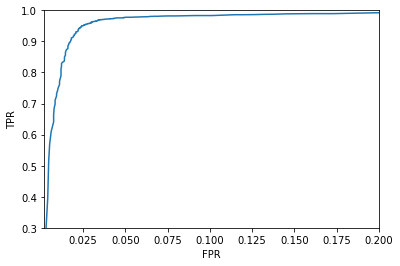

In [18]:
from sklearn.metrics import roc_curve

test_y_int = np.ones_like(test_y, dtype=int)
test_y_int[np.where(test_y == 'GALAXY')] = 0

test_preds_proba = rf_clf.predict_proba(test_X)

fpr, tpr, thresh = roc_curve(test_y_int, test_preds_proba[:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim(2e-3,.2)
ax.set_ylim(0.3,1)

In [19]:
tpr_99_thresh = thresh[np.argmin(np.abs(0.99 - tpr))]

print('This model requires a classification threshold of {:.4f}'.format(tpr_99_thresh))

fpr_at_tpr_99 = fpr[np.argmin(np.abs(0.99 - tpr))]

print('This model misclassifies {:.2f}% of galaxies'.format(fpr_at_tpr_99*100))

This model requires a classification threshold of 0.0400
This model misclassifies 16.02% of galaxies


In [20]:
new_data_df = pd.read_hdf("blind_test_set.h5")

In [21]:
new_X = np.array(new_data_df[feats])
new_y = np.array(new_data_df['class'])

In [22]:
new_preds = rf_clf.predict(new_X)
print("The model has an accuracy of {:.4f}".format(accuracy_score(new_y, new_preds)))

The model has an accuracy of 0.7982


In [24]:
trainnew_X, testnew_X, trainnew_y, testnew_y = train_test_split(new_X, new_y, test_size = 0.3, random_state = rs)

In [27]:
knn_clf = KNeighborsClassifier(n_neighbors=25)
knn_clf.fit(trainnew_X, trainnew_y)

KNeighborsClassifier(n_neighbors=25)

In [28]:
rf_clf = RandomForestClassifier(n_estimators=50, random_state=rs, n_jobs=-1)
rf_clf.fit(trainnew_X, trainnew_y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=1851)

In [29]:
knn_cv = cross_val_score(knn_clf, trainnew_X, trainnew_y, cv=10)

print('The kNN model FoM = {:.4f} +/- {:.4f}'.format(np.mean(knn_cv), np.std(knn_cv, ddof=1)))

The kNN model FoM = 0.9054 +/- 0.0068


In [30]:
test_preds = rf_clf.predict(test_X)

print("The RF model has FoM = {:.4f}".format(accuracy_score(test_y, test_preds)))

The RF model has FoM = 0.5755
